In [ ]:
!pip install ortools

In [ ]:
!pip install Cartopy

In [ ]:
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from google.colab import drive
from sklearn.cluster import KMeans
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/Kinza.xlsx'

In [ ]:
# Read each sheet into a DataFrame
orders = pd.read_excel(file_path, sheet_name='Orders')
customers = pd.read_excel(file_path, sheet_name='Customer')
products = pd.read_excel(file_path, sheet_name='Product')
trucks = pd.read_excel(file_path, sheet_name='Trucks')

In [ ]:
# Display the loaded data
print("Orders:\n", orders.head())
print("Customers:\n", customers.head())
print("Products:\n", products.head())
print("Trucks:\n", trucks.head())

Orders:
    Customer     Invoice          Item  SalesQty
0    100022  INV-001321  CSD-11100103        15
1    100022  INV-001321  CSD-11100107         5
2    100022  INV-001321  CSD-11100109         8
3    100022  INV-001321  CSD-11100110         5
4    100022  INV-001321  CSD-11100112        10
Customers:
    customerNo   Latitude  Longitude
0      102215  21.501795  39.244198
1      104085  21.745882  39.194070
2      103678  21.589452  39.219122
3      104166  21.454958  39.207412
4      101617  21.771004  39.220411
Products:
            Item  Product Name  Can Size\n(in mL)  Can\n(in case)  \
0  CSD-11100101       Lift Up                250          30 Can   
1  CSD-11100102    KINZA COLA                360          24 Can   
2  CSD-11100103    KINZA COLA                250          30 Can   
3  CSD-11100104    KINZA COLA                185          30 Can   
4  CSD-11100105  KINZA Orange                360          24 Can   

  Packaging\n(carton) Pallet Size \n(carton)  Cases per

In [ ]:
print(orders.columns.tolist())
print(customers.columns.tolist())
print(products.columns.tolist())
print(trucks.columns.tolist())

['Customer', 'Invoice', 'Item', 'SalesQty']
['customerNo', 'Latitude', 'Longitude']
['Item', 'Product Name', 'Can Size\n(in mL)', ' Can\n(in case)', 'Packaging\n(carton)', 'Pallet Size \n(carton)', 'Cases per Pallet', 'Gross Carton Weight  \n(in Kg)', 'Carton Length  \n(in cm)', 'Carton Width  \n(in cm)', 'Carton  Height \n(in cm)']
['Truck ID', 'Truck Name', 'Capacity', 'No of Trips', 'Priority']


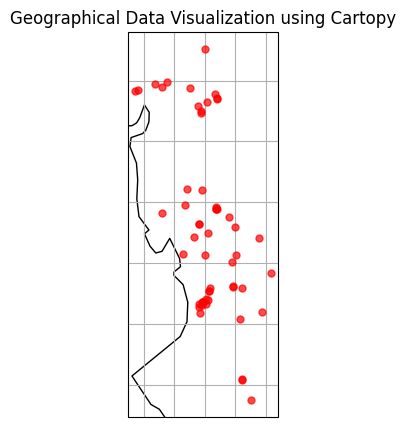

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a figure with a specific projection
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and grid
ax.coastlines()
ax.gridlines()

# Plot each point
for index, row in customers.iterrows():
    ax.plot(row['Longitude'], row['Latitude'], marker='o', color='red', markersize=5, alpha=0.7)

plt.title('Geographical Data Visualization using Cartopy')
plt.show()

In [ ]:
# Clustering customers into 8 clusters
num_trucks = trucks['Truck ID'].nunique()
kmeans = KMeans(n_clusters=num_trucks)
customers['cluster'] = kmeans.fit_predict(customers[['Latitude', 'Longitude']])

In [ ]:
print(customers['cluster'].value_counts())

cluster
4    14
0     9
2     8
5     7
1     6
6     5
7     4
3     3
Name: count, dtype: int64


In [ ]:
# Display clusters with all customers data
for cluster_id in range(num_trucks):
    cluster_customers = customers[customers['cluster'] == cluster_id]

    # Check if the cluster has customers
    if not cluster_customers.empty:
        print(f'Cluster {cluster_id + 1} has {len(cluster_customers)} customers:')
        print(cluster_customers[['customerNo']])
        print()  # Add a newline for better readability
    else:
        print(f'Cluster {cluster_id + 1} is empty.')

Cluster 1 has 4 customers:
    customerNo
16      100956
35      103345
36      100297
39      100491

Cluster 2 has 14 customers:
    customerNo
3       104166
6       102264
7       101747
13      101736
26      101720
28      104174
29      103932
31      101743
34      102231
37      101709
47      101732
51      101737
53      101730
54      101728

Cluster 3 has 5 customers:
    customerNo
10      102985
17      103514
43      100997
48      100022
49      100574

Cluster 4 has 3 customers:
    customerNo
9       100575
11      100480
20      101894

Cluster 5 has 11 customers:
    customerNo
2       103678
12      101745
14      103519
19      102100
24      100388
27      101725
33      101718
40      100258
42      101936
45      101726
46      104054

Cluster 6 has 5 customers:
    customerNo
0       102215
5       101773
15      103836
21      101906
55      102854

Cluster 7 has 9 customers:
    customerNo
1       104085
4       101617
8       103589
18      100192
23      

<ipython-input-84-2785f356a087>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_trucks)


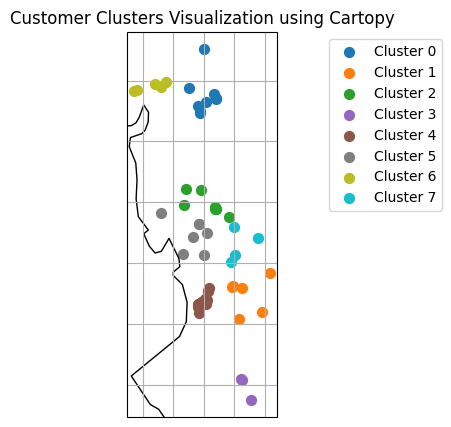

In [ ]:
# Create a figure with a specific projection
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

# Define a color map
colors = plt.cm.get_cmap('tab10', num_trucks)

# Plot each point with a color based on its cluster
for cluster in range(num_trucks):
    cluster_data = customers[customers['cluster'] == cluster]
    ax.scatter(cluster_data['Longitude'], cluster_data['Latitude'],
               color=colors(cluster), label=f'Cluster {cluster}', s=50)

# Position the legend inside the map
plt.title('Customer Clusters Visualization using Cartopy')
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0))  # Adjust as needed
plt.show()

In [ ]:
# Function to create distance matrix
def create_distance_matrix(customers):
    coords = customers[['Latitude', 'Longitude']].to_numpy()
    distance_matrix = np.zeros((len(coords), len(coords)))
    for i in range(len(coords)):
        for j in range(len(coords)):
            distance_matrix[i][j] = np.linalg.norm(coords[i] - coords[j])
    return distance_matrix

In [ ]:
# Function to optimize routes for each cluster
def optimize_routes(customers):
    distance_matrix = create_distance_matrix(customers)
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_trucks, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)  # Convert to integer

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)

    solution = routing.SolveWithParameters(search_parameters)

    routes = []  # Store the routes for visualization
    if solution:
        for i in range(num_trucks):
            index = routing.Start(i)
            route = []
            while not routing.IsEnd(index):
                route.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            routes.append(route)
    else:
        print("No solution found!")

    return routes


In [ ]:
# Optimize routes for each cluster and visualize
map_center = [customers['Latitude'].mean(), customers['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

for cluster_id in range(num_trucks):
    cluster_customers = customers[customers['cluster'] == cluster_id]

    if cluster_customers.empty:
        print(f'Cluster {cluster_id + 1} is empty. Skipping optimization.')
        continue

    # Get optimized routes
    routes = optimize_routes(cluster_customers)

    # Visualize routes on the map
    for i, route in enumerate(routes):
        # Get coordinates for the route
        route_coords = cluster_customers.iloc[route][['Latitude', 'Longitude']].to_numpy()

        # Create a PolyLine for the route
        folium.PolyLine(locations=route_coords, color='blue', weight=2.5, opacity=0.7).add_to(m)

        # Add markers for each customer in the route
        for coord in route_coords:
            folium.Marker(location=[coord[0], coord[1]],
                          popup=f'Cluster {cluster_id + 1}').add_to(m)

# Save the map to an HTML file
m.save('optimized_routes_map.html')

# Display the map in a Jupyter Notebook (if applicable)
m  # Uncomment if using a Jupyter Notebook

In [ ]:
# Step 1: Merge orders with products to get product sizes
orders_with_products = pd.merge(orders, products[['Item', 'Cases per Pallet']], on='Item', how='left')

# Check the merged DataFrame
print("Orders with Products DataFrame columns:", orders_with_products.columns)

# Step 2: Merge with customers to get customer details
orders_with_customers = pd.merge(
    orders_with_products,
    customers[['customerNo']],  # Only include customerNo since there is no 'Customer' in customers
    left_on='Customer',  # This is from the orders DataFrame
    right_on='customerNo',  # This is from the customers DataFrame
    how='left'
)

# Check the merged DataFrame
print("Orders with Customers DataFrame columns:", orders_with_customers.columns)

# Step 3: Group by customer and product size, and sum the quantities
customer_orders_summary = orders_with_customers.groupby(['customerNo', 'Cases per Pallet']).agg({
    'SalesQty': 'sum'  # Assuming 'SalesQty' is the column that contains order quantities
}).reset_index()

# Display the result
print(customer_orders_summary)

Orders with Products DataFrame columns: Index(['Customer', 'Invoice', 'Item', 'SalesQty', 'Cases per Pallet'], dtype='object')
Orders with Customers DataFrame columns: Index(['Customer', 'Invoice', 'Item', 'SalesQty', 'Cases per Pallet',
       'customerNo'],
      dtype='object')
     customerNo  Cases per Pallet  SalesQty
0      100022.0               130        37
1      100022.0               144        66
2      100022.0               192        22
3      100096.0               144       298
4      100096.0               192       384
..          ...               ...       ...
134    104166.0               144        53
135    104166.0               192        24
136    104174.0               130        13
137    104174.0               144        17
138    104174.0               192        19

[139 rows x 3 columns]


In [ ]:
# Ensure 'Cases per Pallet' is not zero to avoid division by zero errors
orders_with_customers['Order Capacity'] = orders_with_customers['SalesQty'] / orders_with_customers['Cases per Pallet'].replace(0, float('nan'))

# Step 4: Group by customer and sum total order capacities
customer_order_capacity_summary = orders_with_customers.groupby(['customerNo']).agg({
    'Order Capacity': 'sum'  # Sum the order capacity for each customer

}).reset_index()

# Display the result
print(customer_order_capacity_summary)

    customerNo  Order Capacity
0     100022.0        0.857532
1     100096.0        4.069444
2     100099.0        0.605288
3     100192.0        7.558494
4     100258.0        0.711645
5     100297.0        1.821848
6     100364.0        3.547837
7     100388.0        0.968483
8     100452.0        2.534722
9     100480.0        5.349225
10    100491.0        0.233440
11    100495.0        0.749306
12    100574.0        0.757532
13    100575.0        0.653446
14    100956.0        1.103632
15    100997.0        0.887821
16    101605.0        3.020513
17    101617.0        0.679220
18    101709.0        7.000000
19    101718.0       82.786859
20    101720.0        1.000000
21    101725.0        4.000000
22    101726.0        1.000000
23    101728.0       17.000000
24    101730.0        7.000000
25    101732.0        2.000000
26    101734.0        1.000000
27    101736.0        8.000000
28    101737.0       17.000000
29    101743.0       74.008494
30    101745.0        9.020833
31    10

In [ ]:
import pandas as pd

# Sample data
clusters = {
    1: [104166, 102264, 101747, 101736, 101720, 104174, 103932, 101743, 102231, 101709, 101732, 101737, 101730, 101728],
    2: [104085, 101617, 103589, 100192, 103947, 100364, 101605, 100495, 101765],
    3: [103678, 101773, 101745, 103519, 103836, 100388, 101725, 101718, 101936, 101726],
    4: [102985, 103514, 100997, 100022, 100574],
    5: [102215, 101906, 100096, 102309, 100099, 101734, 100452, 102854],
    6: [100575, 100480, 101894],
    7: [100956, 103345, 100297, 100491],
    8: [102100, 100258, 104054]
}

# Calculate the total order capacity for each cluster
cluster_order_capacity = {}
for cluster, customers in clusters.items():
    total_capacity = 0
    for customer in customers:
        # Check if the customer exists in the summary DataFrame
        customer_capacity_row = customer_order_capacity_summary[customer_order_capacity_summary['customerNo'] == customer]

        if not customer_capacity_row.empty:
            total_capacity += customer_capacity_row['Order Capacity'].values[0]  # Get the first (and only) value
        else:
            print(f"Warning: Customer {customer} not found in order capacity summary.")

    cluster_order_capacity[cluster] = total_capacity

# Print the cluster order capacities
print(cluster_order_capacity)

{1: 223.35269764957263, 2: 17.6145032051282, 3: 128.62008547008548, 4: 3.0302884615384618, 5: 16.66837606837607, 6: 8.00267094017094, 7: 4.561004273504274, 8: 4.588595085470086}


In [ ]:
# Calculate the total order capacity across all customers
total_order_capacity = customer_order_capacity_summary['Order Capacity'].sum()

# Display the total order capacity
print("Total Order Capacity:", total_order_capacity)

Total Order Capacity: 406.43822115384614


In [ ]:
# Display the truck data
print(trucks)

   Truck ID Truck Name  Capacity  No of Trips  Priority
0         1  TruckA8 1         8            3         8
1         2  TruckB6 1         6            2         1
2         3  TruckB6 2         6            2         2
3         4  TruckB6 3         6            2         3
4         5  TruckB6 4         6            2         4
5         6  TruckB6 5         6            1         5
6         7  TruckB6 6         6            1         6
7         8  TruckB6 7         6            1         7


In [ ]:
# Create a table with cluster information and customer details
cluster_table_data = []
for cluster, customer_list in clusters.items():
  cluster_capacity = 0
  customer_rows = []
  for customer in customer_list:
    customer_capacity_row = customer_order_capacity_summary[
        customer_order_capacity_summary['customerNo'] == customer
    ]
    if not customer_capacity_row.empty:
      customer_capacity = customer_capacity_row['Order Capacity'].values[0]
      customer_rows.append(
          {
              'Customer': customer,
              'Order Capacity': customer_capacity,
          }
      )
      cluster_capacity += customer_capacity

  cluster_table_data.append(
      {
          'Cluster': cluster,
          'Total Order Capacity': cluster_capacity,
          'Customers': pd.DataFrame(customer_rows),
      }
  )

# Display the table
for cluster_data in cluster_table_data:
  print(f'Cluster {cluster_data["Cluster"]}:')
  print(f'  Total Order Capacity: {cluster_data["Total Order Capacity"]}')
  print('  Customers:')
  display(cluster_data['Customers'])
  print('\n')

Cluster 1:
  Total Order Capacity: 223.35269764957263
  Customers:


,Customer,Order Capacity
0,104166,0.808440
1,102264,11.000000
2,101747,11.243056
3,101736,8.000000
4,101720,1.000000
5,104174,0.317014
6,103932,3.000000
7,101743,74.008494
8,102231,63.975694
9,101709,7.000000




Cluster 2:
  Total Order Capacity: 17.6145032051282
  Customers:


,Customer,Order Capacity
0,104085,0.933654
1,101617,0.679220
2,103589,0.408307
3,100192,7.558494
4,103947,0.285310
5,100364,3.547837
6,101605,3.020513
7,100495,0.749306
8,101765,0.431864




Cluster 3:
  Total Order Capacity: 128.62008547008548
  Customers:


,Customer,Order Capacity
0,103678,8.000000
1,101773,1.035470
2,101745,9.020833
3,103519,21.000000
4,103836,0.395406
5,100388,0.968483
6,101725,4.000000
7,101718,82.786859
8,101936,0.413034
9,101726,1.000000




Cluster 4:
  Total Order Capacity: 3.0302884615384618
  Customers:


,Customer,Order Capacity
0,102985,0.337126
1,103514,0.190278
2,100997,0.887821
3,100022,0.857532
4,100574,0.757532




Cluster 5:
  Total Order Capacity: 16.66837606837607
  Customers:


,Customer,Order Capacity
0,102215,7.000000
1,101906,1.213114
2,100096,4.069444
3,102309,0.111111
4,100099,0.605288
5,101734,1.000000
6,100452,2.534722
7,102854,0.134696




Cluster 6:
  Total Order Capacity: 8.00267094017094
  Customers:


,Customer,Order Capacity
0,100575,0.653446
1,100480,5.349225
2,101894,2.000000




Cluster 7:
  Total Order Capacity: 4.561004273504274
  Customers:


,Customer,Order Capacity
0,100956,1.103632
1,103345,1.402083
2,100297,1.821848
3,100491,0.233440




Cluster 8:
  Total Order Capacity: 4.588595085470086
  Customers:


,Customer,Order Capacity
0,102100,3.188034
1,100258,0.711645
2,104054,0.688916


In [ ]:
# Create a DataFrame to store truck assignments
truck_assignments = pd.DataFrame(columns=['Truck ID', 'Cluster', 'Total Order Capacity', 'Trips Needed'])

# Sort trucks by priority (assuming higher priority is better)
trucks_sorted = trucks.sort_values('Priority', ascending=False)

# Assign trucks to clusters based on priority and available capacity
for _, truck_row in trucks_sorted.iterrows():
  truck_id = truck_row['Truck ID']
  truck_capacity = truck_row['Capacity']

  # Find the cluster with the highest order capacity that hasn't been fully assigned
  unassigned_clusters = [
      cluster_data
      for cluster_data in cluster_table_data
      if cluster_data['Cluster'] not in truck_assignments['Cluster'].values
  ]
  if not unassigned_clusters:
      break  # No more unassigned clusters

  unassigned_clusters.sort(key=lambda x: x['Total Order Capacity'], reverse=True)
  cluster_to_assign = unassigned_clusters[0]
  cluster_id = cluster_to_assign['Cluster']
  cluster_order_capacity = cluster_to_assign['Total Order Capacity']

  # Calculate the number of trips needed
  trips_needed = (cluster_order_capacity + truck_capacity - 1) // truck_capacity

  # Update the truck assignments
  truck_assignments = pd.concat(
      [
          truck_assignments,
          pd.DataFrame(
              {
                  'Truck ID': [truck_id],
                  'Cluster': [cluster_id],
                  'Total Order Capacity': [cluster_order_capacity],
                  'Trips Needed': [trips_needed],
              }
          ),
      ],
      ignore_index=True,
  )


# Display the truck assignments
print("Truck Assignments:")
display(truck_assignments)


# Assuming you have the optimized routes as before (in the variable 'routes')
# We will visualize these routes on the map associated with the assigned trucks
for _, row in truck_assignments.iterrows():
    truck_id = row['Truck ID']
    cluster_id = row['Cluster']

    # Filter the customers for the specific cluster
    cluster_customers = customers[customers['cluster'] == cluster_id - 1]

    # Get optimized routes for this cluster (Assuming you have a function or variable 'routes' for each cluster)
    routes = optimize_routes(cluster_customers)  # Replace with your logic to get routes for this cluster

    # Visualize the routes for the current truck on the map
    for i, route in enumerate(routes):
      route_coords = cluster_customers.iloc[route][['Latitude', 'Longitude']].to_numpy()

      folium.PolyLine(locations=route_coords, color='blue', weight=2.5, opacity=0.7).add_to(m)

      for coord in route_coords:
          folium.Marker(location=[coord[0], coord[1]],
                        popup=f'Truck {truck_id} Route - Cluster {cluster_id}').add_to(m)

# Save and display the map
m.save('truck_routes_map.html')
m  # Display the map (optional)

Truck Assignments:


<ipython-input-107-e079f3f4d155>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  truck_assignments = pd.concat(


,Truck ID,Cluster,Total Order Capacity,Trips Needed
0,1,1,223.352698,28.0
1,8,3,128.620085,22.0
2,7,2,17.614503,3.0
3,6,5,16.668376,3.0
4,5,6,8.002671,2.0
5,4,8,4.588595,1.0
6,3,7,4.561004,1.0
7,2,4,3.030288,1.0


In [ ]:
import pandas as pd

# Create a DataFrame to store truck assignments
truck_assignments = pd.DataFrame(columns=['Truck ID', 'Cluster', 'Total Order Capacity', 'Trips Needed'])

# Sort trucks by priority (assuming higher priority is better)
trucks_sorted = trucks.sort_values('Priority', ascending=False)

# Step 1: Assign trucks to their primary clusters based on priority
for _, truck_row in trucks_sorted.iterrows():
    truck_id = truck_row['Truck ID']
    truck_capacity = truck_row['Capacity']

    # Find the cluster with the highest order capacity that hasn't been fully assigned
    unassigned_clusters = [
        cluster_data
        for cluster_data in cluster_table_data
        if cluster_data['Cluster'] not in truck_assignments['Cluster'].values
    ]
    if not unassigned_clusters:
        break  # No more unassigned clusters

    unassigned_clusters.sort(key=lambda x: x['Total Order Capacity'], reverse=True)
    cluster_to_assign = unassigned_clusters[0]
    cluster_id = cluster_to_assign['Cluster']
    cluster_order_capacity = cluster_to_assign['Total Order Capacity']

    # Calculate the number of trips needed
    trips_needed = (cluster_order_capacity + truck_capacity - 1) // truck_capacity

    # Update the truck assignments
    truck_assignments = pd.concat(
        [
            truck_assignments,
            pd.DataFrame(
                {
                    'Truck ID': [truck_id],
                    'Cluster': [cluster_id],
                    'Total Order Capacity': [cluster_order_capacity],
                    'Trips Needed': [trips_needed],
                }
            ),
        ],
        ignore_index=True,
    )

# Step 2: Check for excess capacity and assign additional orders from other clusters
for _, row in truck_assignments.iterrows():
    truck_id = row['Truck ID']
    assigned_cluster_id = row['Cluster']
    assigned_capacity = row['Total Order Capacity']

    # Find the truck's capacity left after its primary assignment
    truck_capacity = trucks.loc[trucks['Truck ID'] == truck_id, 'Capacity'].values[0]
    remaining_capacity = truck_capacity - assigned_capacity

    if remaining_capacity > 0:
        # Check for other clusters to fill the remaining capacity
        for cluster_data in cluster_table_data:
            cluster_id = cluster_data['Cluster']
            cluster_order_capacity = cluster_data['Total Order Capacity']

            # Skip the assigned cluster and check only those that have orders left
            if cluster_id != assigned_cluster_id and cluster_order_capacity > 0:
                if cluster_order_capacity <= remaining_capacity:
                    # Assign all orders from this cluster
                    trips_needed = (cluster_order_capacity + truck_capacity - 1) // truck_capacity

                    truck_assignments = pd.concat(
                        [
                            truck_assignments,
                            pd.DataFrame(
                                {
                                    'Truck ID': [truck_id],
                                    'Cluster': [cluster_id],
                                    'Total Order Capacity': [cluster_order_capacity],
                                    'Trips Needed': [trips_needed],
                                }
                            ),
                        ],
                        ignore_index=True,
                    )

                    # Update the cluster order capacity to zero as it is fully assigned
                    cluster_data['Total Order Capacity'] = 0
                    remaining_capacity -= cluster_order_capacity
                else:
                    # Assign only the remaining capacity
                    trips_needed = (remaining_capacity + truck_capacity - 1) // truck_capacity

                    truck_assignments = pd.concat(
                        [
                            truck_assignments,
                            pd.DataFrame(
                                {
                                    'Truck ID': [truck_id],
                                    'Cluster': [cluster_id],
                                    'Total Order Capacity': [remaining_capacity],
                                    'Trips Needed': [trips_needed],
                                }
                            ),
                        ],
                        ignore_index=True,
                    )

                    # Update the cluster order capacity
                    cluster_data['Total Order Capacity'] -= remaining_capacity
                    remaining_capacity = 0  # Truck is now full

                # Break if the truck is full
                if remaining_capacity <= 0:
                    break

# Display the truck assignments
print("Truck Assignments:")
display(truck_assignments)

import folium
import random


# Create a lighter color palette
colors = [
    'lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow',
    'lightsalmon', 'lightpink', 'lightseagreen', 'lightsteelblue',
    'lavender', 'lightgray'
]

# Assuming the map 'm' is already created
for idx, row in truck_assignments.iterrows():
    truck_id = row['Truck ID']
    cluster_id = row['Cluster']

    # Filter the customers for the specific cluster
    cluster_customers = customers[customers['cluster'] == cluster_id - 1]

    # Get optimized routes for this cluster
    routes = optimize_routes(cluster_customers)  # Replace with your logic to get routes for this cluster

    # Pick a color for this truck's route
    route_color = colors[idx % len(colors)]  # Cycle through the colors

    # Visualize the routes for the current truck on the map
    for i, route in enumerate(routes):
        route_coords = cluster_customers.iloc[route][['Latitude', 'Longitude']].to_numpy()

        folium.PolyLine(locations=route_coords, color=route_color, weight=2.5, opacity=0.7).add_to(m)

        for coord in route_coords:
            folium.Marker(location=[coord[0], coord[1]],
                          popup=f'Truck {truck_id} Route - Cluster {cluster_id}').add_to(m)

# Save and display the map
m.save('truck_routes_map.html')
m  # Display the map (optional)

Truck Assignments:


<ipython-input-112-d5b19bf240f6>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  truck_assignments = pd.concat(


,Truck ID,Cluster,Total Order Capacity,Trips Needed
0,1,1,155.892361,20.0
1,8,3,128.620085,22.0
2,7,2,17.614503,3.0
3,6,5,16.668376,3.0
4,5,6,8.002671,2.0
5,4,8,4.588595,1.0
6,3,7,4.561004,1.0
7,2,4,3.030288,1.0
8,4,1,1.411405,1.0
9,3,1,1.438996,1.0
